Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [30]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [34]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
data_dir_test = pathlib.Path("C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [35]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [36]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [37]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                        # Path to the dataset
    image_size=(img_height, img_width),              # Resize images to this size (height, width)
    batch_size=32,                           # Number of images to return in each batch
    label_mode="int",                         # Labels are returned as integers (can be "int", "categorical", or "binary")
    shuffle=True,                          # Shuffle the data
    seed=123,                           # Seed for reproducibility
    validation_split=0.2,               # Split the data into training and validation sets
    subset="training"                   # Specify whether to load the training subset
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [38]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                      # Path to the dataset
    image_size=(img_height, img_width),  # Resize images to this size (height, width)
    batch_size=32,                       # Number of images to return in each batch
    label_mode="int",                    # Labels are returned as integers (can be "int", "categorical", or "binary")
    shuffle=True,                        # Shuffle the data
    seed=123,                            # Seed for reproducibility
    validation_split=0.2,                # Split the data into training and validation sets
    subset="validation"                  # Specify whether to load the training subset
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [39]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

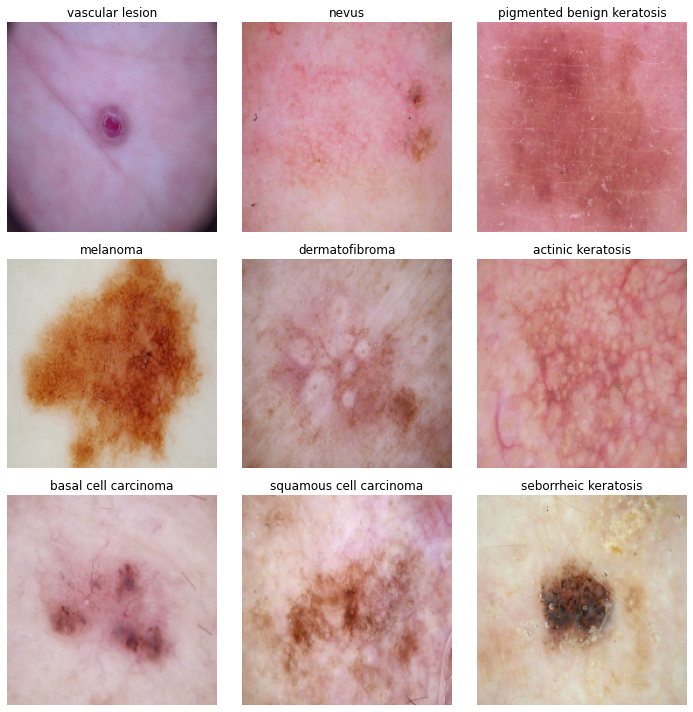

In [40]:
import matplotlib.pyplot as plt
import numpy as np
### your code goes here, you can use training or validation data to visualize

def get_one_instance_per_class(dataset, class_names):
    # initialise instances dictionary
    instances = {}
    # go through images and labels
    for images, labels in dataset:
        for image, label in zip(images, labels):
            # Set class label for the current image 
            class_label = label.numpy()
            
            # if we have not captured the label already, capture it
            if class_label not in instances:
                instances[class_label] = image
            
            # When we have captured one instance of each class return instances
            if len(instances) == len(class_names):
                return instances
    return instances

# Get one image for each class
instances = get_one_instance_per_class(train_ds, class_names)

# Now plot
plt.figure(figsize=(10, 10))

for i, (class_label, image) in enumerate(instances.items()):
    plt.subplot(3, 3, i + 1)  # Create a subplot for each image (adjust 3x3 grid size accordingly)
    plt.imshow(image.numpy().astype("uint8"))  # Convert to uint8 for display
    plt.title(class_names[class_label])  # Set title as the class name
    plt.axis("off")  # Turn off the axes

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [42]:
### Your code goes here

# Input shape of the images
input_shape = (img_height, img_width, 3)

# No of classes
classes = 9

# Define the CNN model
model = Sequential([
    
    # Rescale pixel values from [0, 255] to [0, 1]
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the feature maps into a 1D vector
    layers.Flatten(),
    
    # Dense fully connected layer
    layers.Dense(128, activation='relu'),
    
    # Output layer for classification
    layers.Dense(classes, activation='softmax')  # Softmax for multi-class classification
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [43]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Sparse categorical for integer labels
              metrics=['accuracy'])

In [44]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 41, 41, 128)      

### Train the model

In [45]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 31s 483ms/step - loss: 1.9714 - accuracy: 0.2785 - val_loss: 1.7209 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 27s 484ms/step - loss: 1.5770 - accuracy: 0.4526 - val_loss: 1.4861 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 27s 490ms/step - loss: 1.4398 - accuracy: 0.4833 - val_loss: 1.5366 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 27s 489ms/step - loss: 1.3729 - accuracy: 0.5167 - val_loss: 1.4559 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 27s 486ms/step - loss: 1.2943 - accuracy: 0.5413 - val_loss: 1.3811 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 28s 495ms/step - loss: 1.2255 - accuracy: 0.5619 - val_loss: 1.4903 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 28s 496ms/step - loss: 1.1550 - accuracy: 0.5982 - val_loss: 1.5881 - val_accuracy: 0.4631

### Visualizing training results

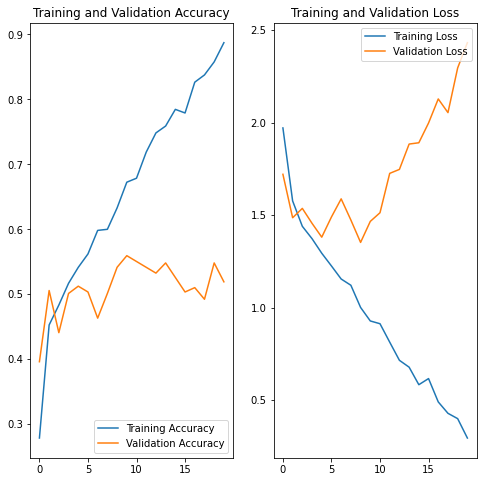

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
### Findings
-> From the training and validation accuracy across epoch's, we can see that training accuracy has improved with every epoch however the validation accuracy started stagnating after 5 epochs. At the end, training accuracy is abount 86 percent and validation accuracy is about 51 percent.      
  
  
-> Higher training accuracy and lower validation accuracy indicates over fitting.  
  
-> Training Loss (Error calcualted at each Epoch) and Validation Loss (Validation loss at each epoch) plot shows the training loss coming down with each epoch whereas the validation loss goes down till  5 epochs and then increases from then on. This indicates that the model is not really learning generalised patterns in data.  
  
-> The Model is clearly overfitting from the data we see from the two plots.

In [47]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Data Augmentation - Flipping, Rotating and Zooming
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])


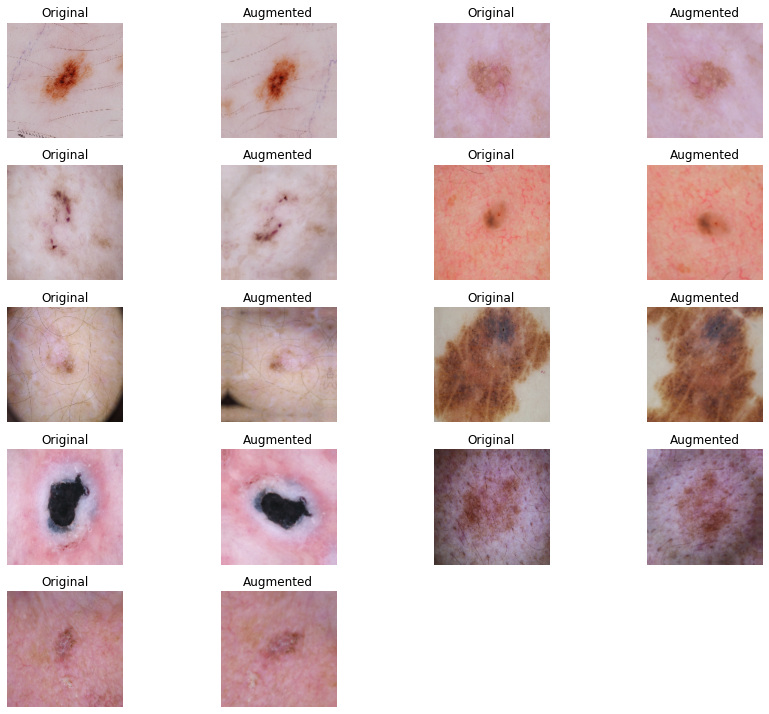

In [48]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Load a batch of images from your dataset
image_batch, label_batch = next(iter(train_ds))

# Apply data augmentation to the batch
augmented_images = data_augmentation(image_batch)

# Visualize both original and augmented images side by side
plt.figure(figsize=(12, 12))
for i in range(9):  # Displaying 9 images
    
    # Display original images
    plt.subplot(6, 4, 2 * i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")
    
    # Display augmented images
    plt.subplot(6, 4, 2 * i + 2)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [56]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# Apart from Data augmenting, going to use Dropout and Regularization
# Define the CNN model with dropout and L2 regularization
from tensorflow.keras import layers, models, regularizers


model = Sequential([
    data_augmentation,
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Dropout(0.3),  # Dropout Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Dropout(0.3),  # Dropout Layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.5),  # Dropout
    layers.Dense(classes, activation='softmax')
])

### Compiling the model

In [57]:
## Your code goes here
model.compile(optimizer='adam',  
              loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

### Training the model

In [58]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 590ms/step - loss: 3.9084 - accuracy: 0.2031 - val_loss: 2.7025 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 34s 601ms/step - loss: 2.4045 - accuracy: 0.2305 - val_loss: 2.2300 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 34s 601ms/step - loss: 2.0932 - accuracy: 0.2667 - val_loss: 1.9722 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 33s 595ms/step - loss: 1.9578 - accuracy: 0.3237 - val_loss: 1.8248 - val_accuracy: 0.4273
Epoch 5/20
56/56 [==============================] - 34s 599ms/step - loss: 1.8475 - accuracy: 0.3577 - val_loss: 1.7783 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 34s 602ms/step - loss: 1.7936 - accuracy: 0.3722 - val_loss: 1.8781 - val_accuracy: 0.3266
Epoch 7/20
56/56 [==============================] - 34s 604ms/step - loss: 1.7948 - accuracy: 0.3739 - val_loss: 1.7046 - val_accuracy: 0.4004

### Visualizing the results

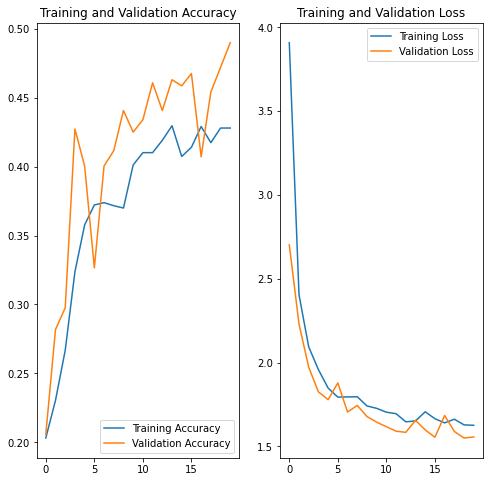

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

-> After adding some dropout layers and Augmenting the data, the new plots tell a differet story.  
-> There is no overfitting now, if you see the accuracy and loss plots, the training and validarion curves are similar
indicating the model is generalising well. Howevery the accuracy is nothing to write home about and the model is underfitting.  
-> This could be because class imbalance as hinted by upGrad.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class counts: Counter({5: 370, 3: 352, 1: 309, 4: 277, 7: 142, 8: 115, 0: 92, 2: 77, 6: 58})


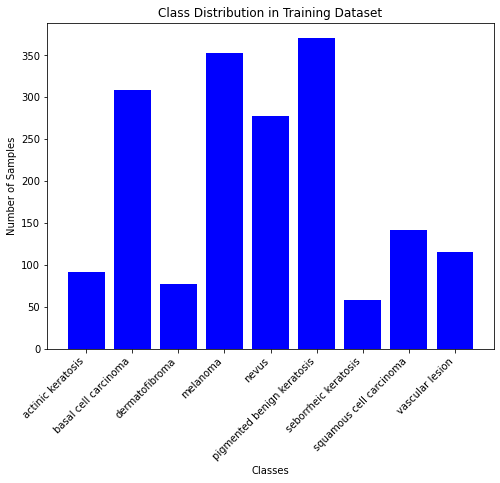

In [60]:
## Your code goes here.
from collections import Counter

# Counter to store class counts
class_counts = Counter()

# Map numerical class labels to actual class names so the plot can be easily understood
class_labels = class_names


# Iterate through the dataset and count the occurrences of each class
for images, labels in train_ds:
    # Flatten labels in case they come in batches (2D array)
    labels = labels.numpy().flatten()
    class_counts.update(labels)

# Print class counts
print("Class counts:", class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45, ha="right")
plt.title('Class Distribution in Training Dataset')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
-> Based on the class distributions, there is definite imbalance in different classes.    
-> Pigmented benign keratosis has the highest number of samples, followed by melanoma and basal cell carcinoma and nevus.  
-> Other than the classes mentioned above, the sample size is quite less and this might be impacting the training and accuracy.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [69]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [61]:
path_to_training_dataset="C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2259D10D0>:   3%| | 13/500 [00:00<00:36, 13.51 Samples/s

Initialised with 114 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D22A5C6130>: 100%|█| 500/500 [00:02<00:00, 188.25 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2259DC430>:   5%| | 23/500 [00:00<00:07, 67.62 Samples/s

Initialised with 376 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D233B6FAF0>: 100%|█| 500/500 [00:02<00:00, 184.19 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D22DC291F0>:   4%| | 18/500 [00:00<00:26, 18.01 Samples/s

Initialised with 95 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D233BBD3A0>: 100%|█| 500/500 [00:02<00:00, 183.32 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D23958E220>: 100%|█| 500/500 [00:13<00
Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x1D22DC80550>:   0%| | 1/500 [00:00<01:28,  5.62 Samples/s

Initialised with 357 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D233B8DCA0>: 100%|█| 500/500 [00:11<00:00, 43.10 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D22437A970>:   4%| | 21/500 [00:00<00:10, 44.70 Samples/s

Initialised with 462 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2204955E0>: 100%|█| 500/500 [00:02<00:00, 181.99 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D233B8DE20>:   0%| | 1/500 [00:00<00:4

Initialised with 77 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1D222635BB0>: 100%|█| 500/500 [00:05<00
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2394B10A0>:   4%| | 21/500 [00:00<00:24, 19.51 Samples/s

Initialised with 181 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D233B8DE50>: 100%|█| 500/500 [00:02<00:00, 188.64 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D22DD6ED90>:   3%| | 14/500 [00:00<00:50,  9.57 Samples/s

Initialised with 139 image(s) found.
Output directory set to C:\Users\ranju\upGrad\CNN_Assignment\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D226F5F820>: 100%|█| 500/500 [00:02<00:00, 182.95 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [62]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [63]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0b609ba7-67b3-46d0-9143-28f681062ae9.jpg',
 'C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1c215084-bc9d-4f41-a98f-046a0f6ba0bd.jpg',
 'C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4bce9af3-c790-4fd3-813f-2004acf297e7.jpg',
 'C:\\Users\\ranju\\upGrad\\CNN_Assignment\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_630a835f-ad4a-4214-acb0-3e3b402fd378.jpg',
 'C:\\Users\\ranju\\upGr

In [64]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [65]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [66]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [67]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
dermatofibroma                500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [107]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [140]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                        # Path to the dataset
    image_size=(img_height, img_width),              # Resize images to this size (height, width)
    batch_size=32,                           # Number of images to return in each batch
    label_mode="int",                         # Labels are returned as integers (can be "int", "categorical", or "binary")
    shuffle=True,                          # Shuffle the data
    seed=123,                           # Seed for reproducibility
    validation_split=0.2,               # Split the data into training and validation sets
    subset="training"                   # Specify whether to load the training subset
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [141]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,                        # Path to the dataset
    image_size=(img_height, img_width),              # Resize images to this size (height, width)
    batch_size=32,                           # Number of images to return in each batch
    label_mode="int",                         # Labels are returned as integers (can be "int", "categorical", or "binary")
    shuffle=True,                          # Shuffle the data
    seed=123,                           # Seed for reproducibility
    validation_split=0.2,               # Split the data into training and validation sets
    subset="validation"                   # Specify whether to load the training subset
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [142]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

#### **Todo:**  Train your model

In [143]:
## your code goes here
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save best model
checkpoint = ModelCheckpoint("best_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor="val_accuracy",patience=8,mode="auto",verbose=1)

classes = 9

model = Sequential([
    
    
    # Conv layer 1
    layers.Rescaling(1./255, input_shape=(180,180,3)),
    # data augmentation
    
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Normalisation and dropout
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    
    # Conv layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Normalisation and dropout
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Conv layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Normalisation and dropout
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Conv layer 4
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Normalisation and dropout
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # flatten
    layers.Flatten(),
    
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.5),  # Dropout
    layers.Dense(classes, activation='softmax')
])

In [144]:
## your code goes here
model.compile(optimizer='Adam',  
              loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

In [145]:
model.build()
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_28 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_108 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_108 (MaxPool  (None, 90, 90, 32)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_63 (Ba  (None, 90, 90, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_88 (Dropout)        (None, 90, 90, 32)      

In [146]:
# your model fit code
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32,
  callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 9.6075 - accuracy: 0.2539
Epoch 1: val_accuracy improved from -inf to 0.14031, saving model to best_model.h5
169/169 [==============================] - 157s 872ms/step - loss: 9.6075 - accuracy: 0.2539 - val_loss: 16.6314 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 4.8764 - accuracy: 0.3058
Epoch 2: val_accuracy improved from 0.14031 to 0.18634, saving model to best_model.h5
169/169 [==============================] - 154s 914ms/step - loss: 4.8764 - accuracy: 0.3058 - val_loss: 8.3051 - val_accuracy: 0.1863
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 2.9338 - accuracy: 0.3286
Epoch 3: val_accuracy did not improve from 0.18634
169/169 [==============================] - 158s 935ms/step - loss: 2.9338 - accuracy: 0.3286 - val_loss: 3.8838 - val_accuracy: 0.1693
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 2.2152 - accurac

#### **Todo:**  Visualize the model results

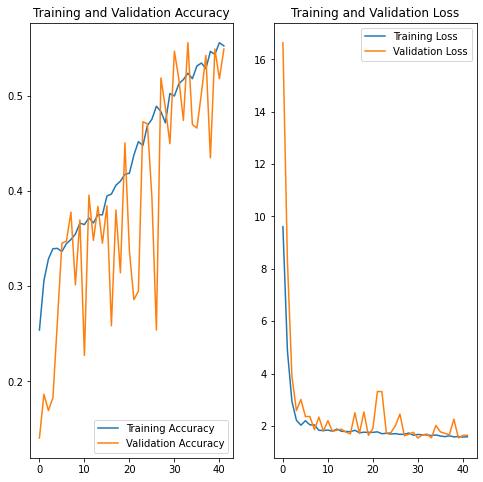

In [151]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(42) # Since early stop stopped at 42 epochs as there is no major imporvement

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

-> The Model still underfits, however there is no overfitting now as evident from accuracy and validation plots and the final numbers. So the class rebalance doesn't seem to have helped